# Putting it all together : photonic systems

In this notebook, we will :

    1) Use zeropdk to create GDS geometries;
    2) Use parallel MEEP to visualize them and efficiently simulate their S-parameters to obtain compact models;
    3) Network many of these components together to overall circuit behaviour with Photontorch
    
In particular, we will simulate a multiring filter. Because FDTD simulations of resonant structures take a long time, we will model the rings as networks of bends :

!['multirings'](images/multirings.png)

Also, we will take very tight rings (bend radius of a few microns), which will require us to actually model the bends instead of simply using a "straight" waveguide for the rings.

# Defining geometries

From the block diagram, there are three topologies we will need to model :

    1) Quarter ring bends (2-port network)
    2) Straight-bend coupling (4-port network)
    3) Bend-bend coupling (4-port network)
    
The straight waveguides will simply be modeled as lossless phase accumulation.

## Layer definition

I define some layers :

In [1]:
import pya
import numpy as np

COMP_CELL = pya.LayerInfo(0, 0)
Si = pya.LayerInfo(1, 0)
MEEP_SOURCE1 = pya.LayerInfo(10, 0)
MEEP_SOURCE2 = pya.LayerInfo(11, 0)
MEEP_PORT1 = pya.LayerInfo(20, 0)
MEEP_PORT2 = pya.LayerInfo(21, 0)
MEEP_PORT3 = pya.LayerInfo(22, 0)
MEEP_PORT4 = pya.LayerInfo(23, 0)

## Quarter ring bends

### Definition

In [2]:
ring_radius = 5 # um
ring_width = 0.5 # um

In [3]:
from zeropdk.layout import layout_arc, layout_waveguide, layout_path, layout_box

layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")

ex = pya.DVector(1, 0)
ey = pya.DVector(0, 1)

# draw simulation region
layout_box(TOP, COMP_CELL, - 0.5*ring_radius*ex - 1.5*ring_radius*ey, 1.5*ring_radius*ex + 0.5*ring_radius*ey, ex)

# draw bend
layout_arc(TOP, Si, - ring_radius*ey, ring_radius, ring_width, 0, np.pi/2)

# Extend the bend to avoid discontinuities
layout_waveguide(TOP, Si, [0*ex, - 0.5*ring_radius*ex], ring_width)
layout_waveguide(TOP, Si, [-1*ring_radius*ey + ring_radius*ex, -1.5*ring_radius*ey + ring_radius*ex], ring_width)

# Add the ports as 0-width paths
port_size = ring_width*4
layout_path(TOP, MEEP_SOURCE1, [-port_size/2*ey - 0.2*ex, port_size/2*ey - 0.2*ex], 0)
layout_path(TOP, MEEP_PORT1, [-port_size/2*ey, port_size/2*ey], 0)
layout_path(TOP, MEEP_PORT2, [-1*ring_radius*ey + ring_radius*ex - port_size/2*ex , -1*ring_radius*ey + ring_radius*ex + port_size/2*ex], 0)

layout.write('bend_zeropdk.gds')
del layout, TOP

### Visualization and simulation

You can download the GDSII file from the cluster (see Files in MyAdroit dashboard) to see it with your local Klayout. Otherwise, let's get simulating :

In [4]:
# Import meep and mpb (from meep)
import meep as mp
from meep import mpb

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

Using MPI version 3.1, 1 processes


In [5]:
res = 32        # pixels/μm

gdsII_file = 'bend_zeropdk.gds'
CELL_LAYER = 0
SOURCE_LAYER = 10
Si_LAYER = 1
PORT1_LAYER = 20
PORT2_LAYER = 21

t_oxide = 1.0
t_Si = 0.22
t_SiO2 = 0.78

dpml = 1
cell_thickness = dpml+t_oxide+t_Si+t_SiO2+dpml
si_zmin = 0

oxide = mp.Medium(epsilon=2.25)
silicon=mp.Medium(epsilon=12)

lcen = 1.55
fcen = 1/lcen
df = 0.2*fcen

cell_zmax =  0
cell_zmin =  0
si_zmax = 0

# read cell size, volumes for source region and flux monitors,
# and coupler geometry from GDSII file
si_layer = mp.get_GDSII_prisms(silicon, gdsII_file, Si_LAYER, si_zmin, si_zmax)

cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, cell_zmin, cell_zmax)
src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, si_zmin, si_zmax)
p1 = mp.GDSII_vol(gdsII_file, 20, si_zmin, si_zmax)
p2 = mp.GDSII_vol(gdsII_file, 21, si_zmin, si_zmax)

In [48]:
def unpack_geometry(geometry, wavelength=1.55, indices = [0,0]):
    """
    returns a 3D numpy array of permittivities vs position for plotting
    Args:
        geometry : a MEEP geometry object
        wavelength : the wavelength at which to report permittivity (in microns)
        indices : the indices of the permittivity tensor to report
    """
    # Read the geometry object
    V = []
    if isinstance(geometry, list):
        for element in geometry:
            eps = element.material.epsilon(wavelength)[indices[0],indices[1]]
            for vertex in element.vertices:
                V.append([[vertex.x, vertex.y, vertex.z], eps])
    else:
        eps = geometry.material.epsilon(wavelength)[indices[0],indices[1]]
        for vertex in geometry.vertices:
            V.append([[vertex.x, vertex.y, vertex.z], eps])
                
    return V

In [6]:
geometry = si_layer

sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                              size=src_vol.size,
                              center=src_vol.center,
                              eig_band=1,
                              eig_parity=mp.EVEN_Y+mp.ODD_Z,
                              eig_match_freq=True)]

# Display simulation object
sim = mp.Simulation(resolution=res,
                    eps_averaging=False,
                    subpixel_maxeval=1,
                    subpixel_tol=1,
                    cell_size=cell.size,
                    boundary_layers=[mp.PML(dpml)],
                    sources=sources,
                    geometry=geometry,
                    geometry_center=mp.Vector3(ring_radius/2, -ring_radius/2))

mode1 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p1))
mode2 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p2))

sim.init_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000216961 s
Working in 2D dimensions.
Computational cell is 10 x 10 x 0 with resolution 32
     prism, center = (3.16414,-1.83585,0)
          height 0, axis (0,0,1), 132 vertices:
          (4.75,-5,0)
          (4.749,-4.883,0)
          (4.744,-4.767,0)
          (4.737,-4.651,0)
          (4.727,-4.534,0)
          (4.714,-4.419,0)
          (4.699,-4.303,0)
          (4.68,-4.188,0)
          (4.659,-4.073,0)
          (4.635,-3.959,0)
          (4.608,-3.846,0)
          (4.578,-3.733,0)
          (4.545,-3.621,0)
          (4.51,-3.51,0)
          (4.472,-3.4,0)
          (4.432,-3.291,0)
          (4.388,-3.182,0)
          (4.342,-3.075,0)
          (4.294,-2.969,0)
          (4.243,-2.864,0)
          (4.189,-2.761,0)
          (4.133,-2.659,0)
          (4.074,-2.558,0)
          (4.013,-2.459,0)
          (3.949,-2.361,0)
          (3.884,-2.265,0)
          (3.815,-2.17,0)
          (3.745,-2.078,0)
  

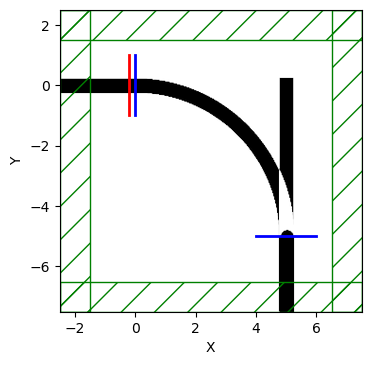

In [7]:
f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()

In [8]:
sim.run(until_after_sources=100)  # We run with a different option, only for some delay after sources are off

Meep progress: 99.828125/177.5 = 56.2% done in 4.0s, 3.1s to go
on time step 6389 (time=99.8281), 0.000626183 s/step
run 0 finished at t = 177.5 (11360 timesteps)
